In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
dataset = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
list(dataset.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'default',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [4]:
# i do some downsample
mtot = dataset['mtot'][:1000]
q = dataset['q'][:1000]
z = dataset['z'][:1000]
det = dataset['det'][:1000]

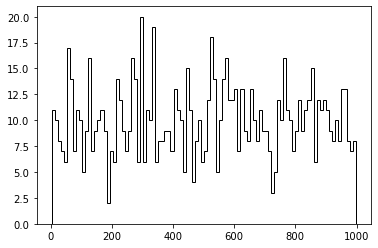

In [5]:
plt.hist(mtot, histtype = 'step', color = 'k', bins=100);

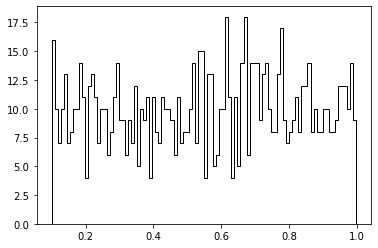

In [6]:
plt.hist(q, histtype = 'step', color = 'k', bins=100);

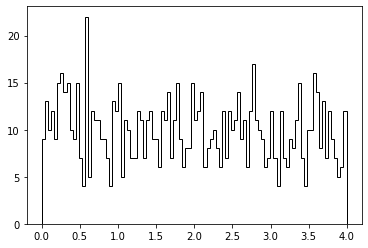

In [7]:
plt.hist(z, histtype = 'step', color = 'k', bins=100);

In [8]:
# try to do something with completeness, contaminations ...

In [9]:
X = np.hstack([mtot[:, np.newaxis], z[:, np.newaxis]])
y = det

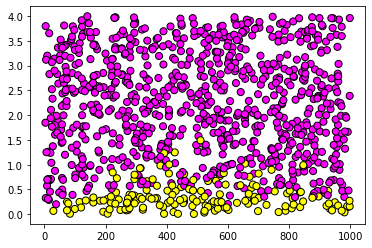

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring', edgecolor='k')

In [11]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
drange = np.arange(1,21)  #Complete

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) #Complete
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 4


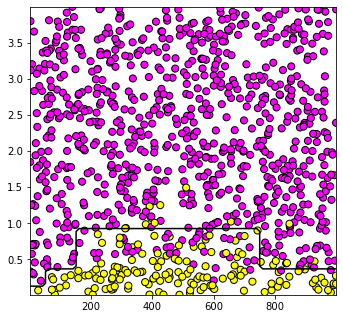

In [12]:
dt = DecisionTreeClassifier(random_state=0, max_depth=best, 
                            criterion='entropy')
dt.fit(X, y)
yprob = dt.predict_proba(X) # If we wanted probabilities rather than the discrete classes

#xlim = (0, 1)
#ylim = (-1, 5)
xlim = (np.min(X[:, 0]), np.max(X[:, 0])) 
ylim = (np.min(X[:, 1]), np.max(X[:, 1]))


xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 51),
                     np.linspace(ylim[0], ylim[1], 51))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, 
                cmap=plt.cm.spring, zorder=2, edgecolor='k')

ax.contour(xx, yy, Z, [0.5], colors='k')

In [13]:
# let's try with bagging
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

In [15]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1)

%timeit bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

428 ms ± 7.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# accuracy
print(accuracy_score(y_test, y_pred_bag))

0.968


In [17]:
#From Geron for plotting the decision boundary
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[np.min(X[:, 0]), np.max(X[:, 0]), 
                                            np.min(X[:, 1]), np.max(X[:, 1])], 
                           alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 
             "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 
             "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

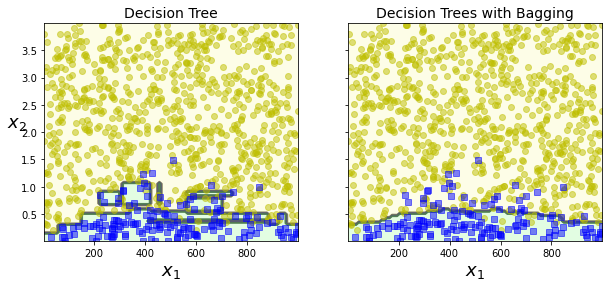

In [18]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.ylabel("")
plt.show()

In [19]:
# let's try with random forest
from sklearn.ensemble import RandomForestClassifier

ranfor = RandomForestClassifier(10)
ranfor.fit(X,y)

y_pred = ranfor.predict(X)

In [32]:
from sklearn.ensemble import RandomForestRegressor

def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    y_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(X_train, y_train)

        y_fit_train = clf.predict(X_train)
        y_fit = clf.predict(X_test)
        rms_train[i] = np.mean(np.sqrt((y_fit_train - y_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((y_fit - y_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            y_fit_best = y_fit

    return rms_test, rms_train, i_best, y_fit_best


depth = np.arange(1, 21)
rms_test, rms_train, i_best, y_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

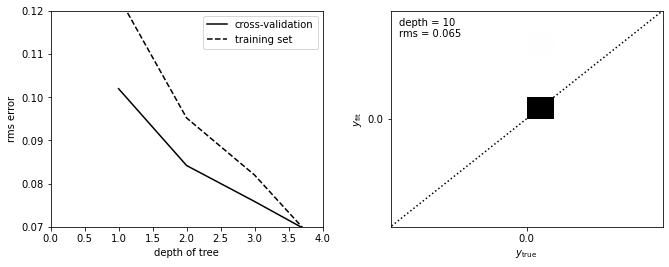

In [33]:
# Plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 4)
ax.set_ylim(0.07,  0.12)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)

edges = np.linspace(y_test.min(), y_test.max(), 101)
H, ys_bins, yp_bins = np.histogram2d(y_test, y_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[ys_bins[0], ys_bins[-1], ys_bins[0], ys_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$y_{\rm true}$')
ax.set_ylabel(r'$y_{\rm fit}$')

ax.set_xlim(-0.05, 0.05)
ax.set_ylim(-0.05, 0.05)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()